# Install

In [1]:
!pip install polars_ml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.5/31.5 MB 16.3 MB/s eta 0:00:00
  Attempting uninstall: polars
    Found existing installation: polars 0.20.2
    Uninstalling polars-0.20.2:
      Successfully uninstalled polars-0.20.2


# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import polars as pl

# Create Toy Graph

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


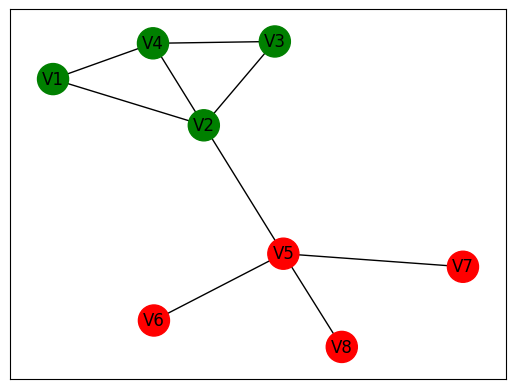

In [3]:
def dataframe_to_networkx(df, src_col, dst_col):
    G = nx.Graph()
    for index, row in df.iterrows():
        G.add_edge(row[src_col], row[dst_col])
    return G

graph_pd = pd.DataFrame([['V1','V2'], ['V2','V1'], ['V2','V3'], ['V3','V2'],
                         ['V4','V2'],['V2','V4'], ['V4','V3'], ['V3', 'V4'], ['V5','V6'], ['V6','V5'],['V5','V7'],
                         ['V7','V5'], ['V2','V5'],['V5','V2'], ['V8','V5'], ['V5', 'V8'],
                         ['V4', 'V1'], ['V1', 'V4']], columns=['SRC','DST'])

graph = dataframe_to_networkx(graph_pd, src_col='SRC', dst_col='DST')

gt_df = pd.DataFrame([['V5',0], ['V6',0], ['V7',0], ['V1',1], ['V3',1],
                      ['V8',0], ['V2',1], ['V4',1]], columns=['NODE','LABEL'])

# visualize graph
def get_colors(df):
    colors = []
    for node in graph.nodes():
        if node in df['NODE'].tolist():
            if df[df['NODE'] == node]['LABEL'].tolist()[0] == 1:
                colors.append('Green')
            else:
                colors.append('Red')
        else:
            colors.append('Yellow')
    return colors

colors = get_colors(gt_df)
pos = nx.spring_layout(graph)
nx.draw_networkx_nodes(graph, pos, cmap=plt.get_cmap('jet'), node_color = colors, node_size = 500)
nx.draw_networkx_labels(graph, pos)
nx.draw_networkx_edges(graph, pos)
plt.show()

# Run Node2vec

In [4]:
import polars_ml as plm

# convert to polars
graph_df = pl.DataFrame(graph_pd).group_by('SRC').agg('DST')

embedding_df = graph_df.lazy().with_columns(
    plm.graph.node2vec(source_node=pl.col('SRC'),
                       neighbors=pl.col('DST'),
                       is_directed=False,
                       max_neighbors=None,
                       embedding_size=64,
                       model_type='skipgram',
                       random_state=42,
                       verbose=True).alias('embedding')
).select('SRC', 'embedding').collect()

In [5]:
embedding_pd = embedding_df.with_columns(pl.col('embedding').list.to_struct()) \
  .unnest('embedding') \
  .to_pandas().set_index('SRC')

embedding_pd.head()

,field_0,field_1,field_2,field_3,field_4,field_5,field_6,field_7,field_8,field_9,...,field_54,field_55,field_56,field_57,field_58,field_59,field_60,field_61,field_62,field_63
SRC,,,,,,,,,,,,,,,,,,,,,
V4,-0.224431,-0.415697,-0.652678,-0.155796,0.149354,-0.127773,0.800565,0.238975,-0.165729,0.061265,...,-0.432685,0.227645,0.034233,0.169721,-0.254886,-0.374091,0.355921,-0.148028,0.033050,0.505503
V3,-0.116671,-0.431402,-0.319156,0.066667,0.289948,-0.383080,0.649500,0.289690,-0.228944,-0.222225,...,-0.493913,0.266061,-0.130195,0.114678,-0.419821,-0.228478,0.231449,-0.133988,0.220421,0.347610
V7,0.284787,0.627132,0.817328,0.323808,-0.369074,0.633266,-0.864487,-0.234190,0.140728,0.085218,...,0.663775,-0.217068,0.266977,-0.356538,0.496231,0.645030,-0.533464,0.020272,0.333691,-0.550852
V2,0.557103,-0.211397,-0.227451,-0.067185,0.122498,0.029097,0.313805,-0.217784,0.006129,-0.416615,...,-0.463869,0.084170,-0.173030,-0.385016,-0.373390,0.301145,-0.641599,0.083233,0.506448,0.149672
V5,0.885090,0.613186,0.725879,0.208049,-0.607098,0.709555,-0.630788,-0.160291,0.200713,-0.141821,...,0.219998,-0.149055,0.190341,-0.441907,-0.001720,0.664051,-0.934173,0.168307,0.517847,-0.456672


# KMEANS Clustering

In [6]:
import numpy as np
import itertools
from sklearn.cluster import KMeans

NUM_CLUSTERS = 2

kmeans = KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(embedding_pd)
labels = kmeans.predict(embedding_pd)
embedding_clusters_pd = embedding_pd.copy()
embedding_clusters_pd['cluster'] = labels
clusters_pd = embedding_clusters_pd.reset_index()[['SRC','cluster']]
clusters_pd

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,SRC,cluster
0,V4,0
1,V3,0
2,V7,1
3,V2,0
4,V5,1
5,V6,1
6,V1,0
7,V8,1


# Plot Clusters

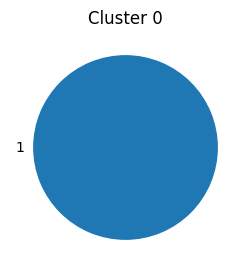

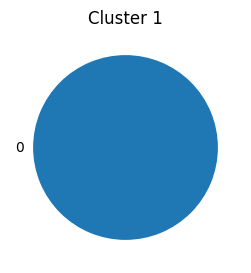

In [10]:
def plot_clusters(clusters_pd, gt_pd, gt_label_col, cluster_col, id_col):
  clusters_with_labels_pd = pd.merge(gt_pd, clusters_pd, on=id_col, how='inner')
  clusters_grouped_pd = clusters_with_labels_pd.groupby([cluster_col, gt_label_col]).agg({id_col: 'count'}).reset_index()
  all_clusters = clusters_pd[cluster_col].unique().tolist()

  for cluster in all_clusters:
      single_cluster_with_labels_pd = clusters_grouped_pd[clusters_grouped_pd[cluster_col] == cluster]
      fig = plt.figure(figsize=(5, 3))
      plt.pie(single_cluster_with_labels_pd[id_col], labels=single_cluster_with_labels_pd[gt_label_col])
      plt.title(f'Cluster {cluster}')
      plt.show()

plot_clusters(clusters_pd.rename(columns={'SRC': 'NODE'}), gt_df,
              gt_label_col='LABEL', id_col='NODE', cluster_col='cluster')